# The Trail Foundation - Forecasting Trail Traffic for Crenshaw Bridge

## Imports

This is where we import the libraries we need for this exercise.

In [31]:
import numpy as np
import pandas as pd
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, iplot_mpl
from scipy.optimize import leastsq

init_notebook_mode(connected=True)

## Data Ingestion

### Data Importing

The data is contained within the *daily_counts_7-2-19.xlsx* file. We import this and observe that the data was parsed correctly.

In [32]:
trail_df = pd.read_csv('daily_counts_10-25-19.csv')

trail_df = trail_df.rename(index=str, columns={"Time": "Date"})
trail_df.columns = ['Date', 'Butler Trail - Crenshaw Bridge PC Urban Trail', 
                    'Butler Trail - South Lamar PC Urban Trail', 'Butler Trail - North Congress PC Urban Trail',
                   'Butler Trail - Longhorn Dam PC Urban Trail', 'Shoal Creek Solar Trail PC Urban Trail ped/bike']

trail_df

,Date,Butler Trail - Crenshaw Bridge PC Urban Trail,Butler Trail - South Lamar PC Urban Trail,Butler Trail - North Congress PC Urban Trail,Butler Trail - Longhorn Dam PC Urban Trail,Shoal Creek Solar Trail PC Urban Trail ped/bike
0,2/17/16 0:00,4242.0,NaN,NaN,NaN,NaN
1,2/18/16 0:00,4979.0,NaN,NaN,NaN,NaN
2,2/19/16 0:00,5002.0,NaN,NaN,NaN,NaN
3,2/20/16 0:00,7697.0,NaN,NaN,NaN,NaN
4,2/21/16 0:00,5958.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1341,10/20/19 0:00,2510.0,2510.0,NaN,1699.0,329.0
1342,10/21/19 0:00,2839.0,2911.0,NaN,961.0,674.0
1343,10/22/19 0:00,3101.0,2753.0,NaN,918.0,483.0
1344,10/23/19 0:00,2107.0,1995.0,NaN,987.0,329.0


### Data Cleaning

There are several validations and cleaning steps we should do before analyzing the data. Let's take a look at some descriptive statistics to make sure the ranges for the column values are reasonable and see how the NaNs are being handled.

In [33]:
trail_df.shape

(1346, 6)

In [34]:
trail_df.describe()

,Butler Trail - Crenshaw Bridge PC Urban Trail,Butler Trail - South Lamar PC Urban Trail,Butler Trail - North Congress PC Urban Trail,Butler Trail - Longhorn Dam PC Urban Trail,Shoal Creek Solar Trail PC Urban Trail ped/bike
count,1297.000000,571.000000,567.000000,539.000000,807.000000
mean,4021.160370,2554.957968,2985.592593,948.474954,266.263941
std,2480.562293,1613.786218,1333.612252,470.920084,266.157994
min,224.000000,94.000000,332.000000,1.000000,1.000000
25%,2721.000000,1648.500000,2044.500000,730.500000,124.500000
50%,3801.000000,2278.000000,2792.000000,910.000000,191.000000
75%,4906.000000,3277.000000,3655.000000,1202.000000,329.000000
max,20530.000000,21729.000000,10374.000000,2569.000000,3061.000000


This looks right. `trail_df` is 1346 rows long, and the most entries any column has is 1297. Some have far fewer, likely because there wasn't a counter installed on the trail yet. It also appears that Pandas ignores NaNs instead of including them in counts or infilling them. I'm adding a month column since we will want to use that later.

In [35]:
trail_df['Date'] = pd.to_datetime(trail_df['Date'])  #converting to datetime format

In [36]:
trail_df['Butler Trail - Crenshaw Bridge PC Urban Trail'] = trail_df['Butler Trail - Crenshaw Bridge PC Urban Trail'].replace(0, np.nan)  #replacing with nan
trail_df['month'] = trail_df['Date'].dt.month                                                                                             #converting to month
trail_df['Butler Trail - Crenshaw Bridge PC Urban Trail'] = trail_df['Butler Trail - Crenshaw Bridge PC Urban Trail'].astype(float)       #converting to float type


In [37]:
trail_df.dtypes

Date                                               datetime64[ns]
Butler Trail - Crenshaw Bridge PC Urban Trail             float64
Butler Trail - South Lamar PC Urban Trail                 float64
Butler Trail - North Congress PC Urban Trail              float64
Butler Trail - Longhorn Dam PC Urban Trail                float64
Shoal Creek Solar Trail PC Urban Trail ped/bike           float64
month                                                       int64
dtype: object

### Data Processing
The models need the data in different formats.

In [38]:
from matplotlib import pyplot
from matplotlib import figure

from pandas import read_csv
from pandas import datetime
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error


%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I want to only work with the period that has values for Butler-Crenshaw since that goes back the farthest. Before I start building and evaluating models on that data, I need to decide how to take care of the missing values from 6/9/18 - 7/27/18. I don't want to lose 3 years of data by starting at the end of this, so I'm going to put in average values for the missing dates (accounting for the day of the week that it is).

In [39]:
crenshaw_df = trail_df.copy()
crenshaw_df['week'] = crenshaw_df['Date'].dt.week
crenshaw_df['day'] = crenshaw_df['Date'].dt.dayofweek

In [40]:
crenshaw_df.head()

,Date,Butler Trail - Crenshaw Bridge PC Urban Trail,Butler Trail - South Lamar PC Urban Trail,Butler Trail - North Congress PC Urban Trail,Butler Trail - Longhorn Dam PC Urban Trail,Shoal Creek Solar Trail PC Urban Trail ped/bike,month,week,day
0,2016-02-17,4242.0,NaN,NaN,NaN,NaN,2,7,2
1,2016-02-18,4979.0,NaN,NaN,NaN,NaN,2,7,3
2,2016-02-19,5002.0,NaN,NaN,NaN,NaN,2,7,4
3,2016-02-20,7697.0,NaN,NaN,NaN,NaN,2,7,5
4,2016-02-21,5958.0,NaN,NaN,NaN,NaN,2,7,6


In [41]:
nan_idxs = list(np.where(crenshaw_df['Butler Trail - Crenshaw Bridge PC Urban Trail'].isnull())[0])

For every row in nan_idxs:
* Select all *other* (excluding current) instances in the dataset with that same week and day.
* Take the mean count for those days for Crenshaw
* Replace count (currently NaN) for row with mean count

In [42]:
inverse_df = crenshaw_df.drop(crenshaw_df.index[nan_idxs])    #no null values

In [43]:
print(inverse_df.shape)
print(trail_df.shape)

(1297, 9)
(1346, 7)


In [44]:
def impute_nans(nan_row):
    week = nan_row['week']
    day = nan_row['day']
    temp_df = inverse_df.query('week=={} and day=={}'.format(week, day))
    new_val = temp_df['Butler Trail - Crenshaw Bridge PC Urban Trail'].mean()
    return new_val

In [45]:
crenshaw_df.iloc[nan_idxs]

,Date,Butler Trail - Crenshaw Bridge PC Urban Trail,Butler Trail - South Lamar PC Urban Trail,Butler Trail - North Congress PC Urban Trail,Butler Trail - Longhorn Dam PC Urban Trail,Shoal Creek Solar Trail PC Urban Trail ped/bike,month,week,day
843,2018-06-09,NaN,4231.0,4363.0,1559.0,495.0,6,23,5
844,2018-06-10,NaN,3310.0,3720.0,1629.0,423.0,6,23,6
845,2018-06-11,NaN,1931.0,2510.0,1208.0,371.0,6,24,0
846,2018-06-12,NaN,2001.0,2615.0,986.0,363.0,6,24,1
847,2018-06-13,NaN,2232.0,2616.0,984.0,343.0,6,24,2
848,2018-06-14,NaN,2214.0,2846.0,1761.0,510.0,6,24,3
849,2018-06-15,NaN,2223.0,2945.0,1026.0,302.0,6,24,4
850,2018-06-16,NaN,4130.0,4457.0,1453.0,406.0,6,24,5
851,2018-06-17,NaN,3965.0,3957.0,1466.0,484.0,6,24,6
852,2018-06-18,NaN,2260.0,2696.0,717.0,489.0,6,25,0


In [46]:
nan_df = crenshaw_df.iloc[nan_idxs]
nan_df['Butler Trail - Crenshaw Bridge PC Urban Trail'] = nan_df.apply(impute_nans, axis=1)

C:\Users\mayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
# NaN values are now replaced with the imputed values created above.
crenshaw_df.iloc[nan_idxs] = nan_df

In [48]:
# Imputed
crenshaw_df.iloc[nan_idxs]

,Date,Butler Trail - Crenshaw Bridge PC Urban Trail,Butler Trail - South Lamar PC Urban Trail,Butler Trail - North Congress PC Urban Trail,Butler Trail - Longhorn Dam PC Urban Trail,Shoal Creek Solar Trail PC Urban Trail ped/bike,month,week,day
843,2018-06-09,4883.000000,4231.0,4363.0,1559.0,495.0,6,23,5
844,2018-06-10,4303.333333,3310.0,3720.0,1629.0,423.0,6,23,6
845,2018-06-11,2832.666667,1931.0,2510.0,1208.0,371.0,6,24,0
846,2018-06-12,3314.000000,2001.0,2615.0,986.0,363.0,6,24,1
847,2018-06-13,4594.666667,2232.0,2616.0,984.0,343.0,6,24,2
848,2018-06-14,2913.666667,2214.0,2846.0,1761.0,510.0,6,24,3
849,2018-06-15,2649.666667,2223.0,2945.0,1026.0,302.0,6,24,4
850,2018-06-16,3903.000000,4130.0,4457.0,1453.0,406.0,6,24,5
851,2018-06-17,3488.666667,3965.0,3957.0,1466.0,484.0,6,24,6
852,2018-06-18,2901.333333,2260.0,2696.0,717.0,489.0,6,25,0


In [49]:
# Creating a copy of crenshaw and merging with weather data
multivariate_df = crenshaw_df.copy()
multivariate_df = multivariate_df.set_index('Date')

weather_df = pd.read_csv('weather_10-22-19.csv')
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
weather_df = weather_df.set_index('DATE')

multivariate_df = pd.merge(multivariate_df, weather_df, how='inner', left_index=True, right_index=True)

multivariate_df = multivariate_df.drop(columns=['STATION', 'NAME', 
                                                'Butler Trail - South Lamar PC Urban Trail', 
                                                'Butler Trail - North Congress PC Urban Trail', 
                                                'Butler Trail - Longhorn Dam PC Urban Trail', 
                                                'Shoal Creek Solar Trail PC Urban Trail ped/bike'])

multivariate_df.head()

,Butler Trail - Crenshaw Bridge PC Urban Trail,month,week,day,PRCP,TMAX,TMIN
2016-02-17,4242.0,2,7,2,0.0,79,45
2016-02-18,4979.0,2,7,3,0.0,73,46
2016-02-19,5002.0,2,7,4,0.0,77,53
2016-02-20,7697.0,2,7,5,0.0,79,62
2016-02-21,5958.0,2,7,6,0.0,73,63


In [50]:
np.setdiff1d(crenshaw_df.Date.values,multivariate_df.index.values)   # missing weather data days 

array(['2019-10-23T00:00:00.000000000', '2019-10-24T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [51]:
#Converting week into week of month
from datetime import datetime
import pendulum
for i in range(0,len(multivariate_df.index)):
    dateTimeObj = multivariate_df.index[i]
    timestampStr = dateTimeObj.strftime("%Y-%m-%d")
    multivariate_df.loc[dateTimeObj,'week_of_month']=pendulum.parse(timestampStr).week_of_month
    
multivariate_df['Date'] = multivariate_df.index


In [52]:
multivariate_df['year']=multivariate_df['Date'].dt.year
multivariate_df.head(10)

,Butler Trail - Crenshaw Bridge PC Urban Trail,month,week,day,PRCP,TMAX,TMIN,week_of_month,Date,year
2016-02-17,4242.0,2,7,2,0.00,79,45,3.0,2016-02-17,2016
2016-02-18,4979.0,2,7,3,0.00,73,46,3.0,2016-02-18,2016
2016-02-19,5002.0,2,7,4,0.00,77,53,3.0,2016-02-19,2016
2016-02-20,7697.0,2,7,5,0.00,79,62,3.0,2016-02-20,2016
2016-02-21,5958.0,2,7,6,0.00,73,63,3.0,2016-02-21,2016
2016-02-22,4289.0,2,8,0,0.01,68,57,4.0,2016-02-22,2016
2016-02-23,2337.0,2,8,1,1.38,72,54,4.0,2016-02-23,2016
2016-02-24,3888.0,2,8,2,0.00,55,41,4.0,2016-02-24,2016
2016-02-25,4563.0,2,8,3,0.00,64,35,4.0,2016-02-25,2016
2016-02-26,4266.0,2,8,4,0.00,67,35,4.0,2016-02-26,2016


In [56]:
trace1 = go.Scatter(x=multivariate_df['Date'], y=multivariate_df['Butler Trail - Crenshaw Bridge PC Urban Trail'],name='Count')

data=trace1
layout = go.Layout(title='Daily traffic count at Crenshaw', legend=dict(x=-.1, y=1.1))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [57]:
multivariate_df.describe()

,Butler Trail - Crenshaw Bridge PC Urban Trail,month,week,day,PRCP,TMAX,TMIN,week_of_month,year
count,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000
mean,3986.971478,6.454613,26.178571,3.000000,0.104516,80.154018,58.438244,2.700149,2017.473214
std,2447.342594,3.280987,14.278924,2.000744,0.346611,14.839903,14.249110,1.265900,1.078814
min,224.000000,1.000000,1.000000,0.000000,0.000000,25.000000,14.000000,1.000000,2016.000000
25%,2697.250000,4.000000,14.000000,1.000000,0.000000,71.000000,47.000000,2.000000,2017.000000
50%,3735.500000,6.000000,26.000000,3.000000,0.000000,82.000000,61.000000,3.000000,2017.000000
75%,4874.500000,9.000000,38.000000,5.000000,0.000000,92.000000,72.000000,4.000000,2018.000000
max,20530.000000,12.000000,52.000000,6.000000,3.290000,108.000000,78.000000,5.000000,2019.000000


In [58]:
#Outliers are replaced with the imputed values created using impute nans

multivariate_df_imputed=multivariate_df.copy()
indexer=multivariate_df_imputed['Butler Trail - Crenshaw Bridge PC Urban Trail']>=11000   # count above 11k is considered an outlier
inverse_df=multivariate_df_imputed.drop(multivariate_df_imputed[indexer].index)       #df without outlier rows

multivariate_df_imputed.loc[multivariate_df_imputed['Butler Trail - Crenshaw Bridge PC Urban Trail']>=11000,'Butler Trail - Crenshaw Bridge PC Urban Trail']=0  #imputing 0 values for 11k and above count and imputing later with the mean value day and week

multivariate_df_imputed.loc[indexer,'Butler Trail - Crenshaw Bridge PC Urban Trail']=multivariate_df_imputed[indexer].apply(impute_nans,axis=1)


In [59]:
multivariate_df_imputed.describe()

,Butler Trail - Crenshaw Bridge PC Urban Trail,month,week,day,PRCP,TMAX,TMIN,week_of_month,year
count,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000
mean,3785.663442,6.454613,26.178571,3.000000,0.104516,80.154018,58.438244,2.700149,2017.473214
std,1773.787055,3.280987,14.278924,2.000744,0.346611,14.839903,14.249110,1.265900,1.078814
min,224.000000,1.000000,1.000000,0.000000,0.000000,25.000000,14.000000,1.000000,2016.000000
25%,2690.250000,4.000000,14.000000,1.000000,0.000000,71.000000,47.000000,2.000000,2017.000000
50%,3726.500000,6.000000,26.000000,3.000000,0.000000,82.000000,61.000000,3.000000,2017.000000
75%,4829.250000,9.000000,38.000000,5.000000,0.000000,92.000000,72.000000,4.000000,2018.000000
max,10090.000000,12.000000,52.000000,6.000000,3.290000,108.000000,78.000000,5.000000,2019.000000


## Forecasting

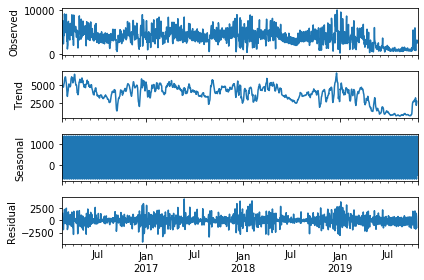

<Figure size 28800x43200 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
sm.tsa.seasonal_decompose(multivariate_df_imputed['Butler Trail - Crenshaw Bridge PC Urban Trail']).plot()
plt.figure(figsize=(400,600))
plt.show()

As we can see from the above graphs, we can say that there is no promimnent trend. We see a good amount of seasonality. The time series can be treated as stationary and we proceed to model fitting.


### Train Test split

In [61]:
# We are training on 21 months of historical data and we use last three months of data to test the accuracy of the model.
date_splitter='2019-08-01'
train, test = multivariate_df_imputed[:date_splitter], multivariate_df_imputed[date_splitter:]

Text(0, 0.5, 'Count')

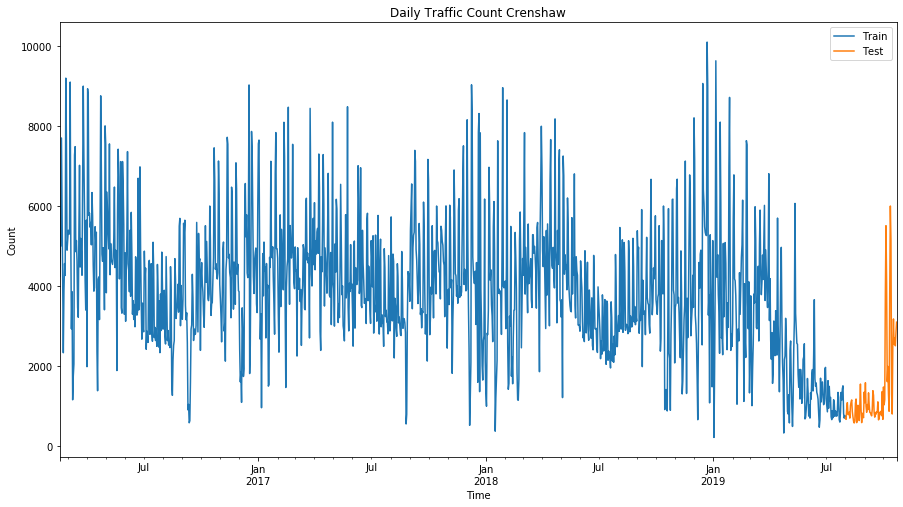

In [62]:
#Plot for train and test data
import matplotlib.pyplot as plt
train['Butler Trail - Crenshaw Bridge PC Urban Trail'].plot(label = 'Train')
test['Butler Trail - Crenshaw Bridge PC Urban Trail'].plot(label="Test", figsize = (15,8))
plt.legend()
plt.title('Daily Traffic Count Crenshaw')
plt.xlabel('Time')
plt.ylabel('Count')

### Grid search for parameter tuning for SARIMA modeling

In [237]:
# import itertools
# #Defining parameters p, d, q to take value from 0 to 2
# p = d = q = range(0,3)

# # Generate all different combinations of p, q and q triplets
# pdq=list(itertools.product(p,d,q))

# # Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [71]:
# %%time
# import warnings
# import statsmodels.api as sm
# warnings.filterwarnings("ignore") # specify to ignore warning messages
# arr=[]
# min_aic = 1e64
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#             mod = sm.tsa.statespace.SARIMAX(multivariate_df_imputed['Butler Trail - Crenshaw Bridge PC Urban Trail'],
#                                             order=param,
#                                             seasonal_order=param_seasonal, enforce_invertibility=False,
#                                             enforce_stationarity=False
#                                             )

#             results = mod.fit()
#             arr.append(results.aic)
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
#             if results.aic < min_aic:
#                 min_aic = results.aic
#                 best_param,best_param_seasonal = param, param_seasonal

# print(min(arr), 'ARIMA{}x{} - AIC:{}'.format(best_param, best_param_seasonal))

ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:26209.503162031084
ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:24978.13578736841
ARIMA(0, 0, 0)x(0, 0, 2, 7) - AIC:24384.760204938008
ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:23544.668177470754
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:22826.33464586888
ARIMA(0, 0, 0)x(0, 1, 2, 7) - AIC:22697.072633942265
ARIMA(0, 0, 0)x(0, 2, 0, 7) - AIC:24805.61662183483
ARIMA(0, 0, 0)x(0, 2, 1, 7) - AIC:23370.089850714132
ARIMA(0, 0, 0)x(0, 2, 2, 7) - AIC:22880.009649908054
ARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:23508.16703140508
ARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:22984.21912354861
ARIMA(0, 0, 0)x(1, 0, 2, 7) - AIC:22815.393977671207
ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:23184.273241775056
ARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:22827.29572946708
ARIMA(0, 0, 0)x(1, 1, 2, 7) - AIC:22685.29640912108
ARIMA(0, 0, 0)x(1, 2, 0, 7) - AIC:24133.63552876326
ARIMA(0, 0, 0)x(1, 2, 1, 7) - AIC:23179.65525091467
ARIMA(0, 0, 0)x(1, 2, 2, 7) - AIC:22803.971341577202
ARIMA(0, 0, 0)x(2, 0, 0, 7) - AIC:23159.436822980722
AR

ARIMA(0, 1, 2)x(2, 1, 0, 7) - AIC:22592.89636573806
ARIMA(0, 1, 2)x(2, 1, 1, 7) - AIC:22335.324298585914
ARIMA(0, 1, 2)x(2, 1, 2, 7) - AIC:22278.979724747565
ARIMA(0, 1, 2)x(2, 2, 0, 7) - AIC:23794.697314572102
ARIMA(0, 1, 2)x(2, 2, 1, 7) - AIC:22517.662950147518
ARIMA(0, 1, 2)x(2, 2, 2, 7) - AIC:23484.515592262673
ARIMA(0, 2, 0)x(0, 0, 0, 7) - AIC:24818.217029630978
ARIMA(0, 2, 0)x(0, 0, 1, 7) - AIC:24563.21641565344
ARIMA(0, 2, 0)x(0, 0, 2, 7) - AIC:24403.602680621356
ARIMA(0, 2, 0)x(0, 1, 0, 7) - AIC:25027.71546797259
ARIMA(0, 2, 0)x(0, 1, 1, 7) - AIC:24211.42008806023
ARIMA(0, 2, 0)x(0, 1, 2, 7) - AIC:24072.3385936917
ARIMA(0, 2, 0)x(0, 2, 0, 7) - AIC:26318.52118214213
ARIMA(0, 2, 0)x(0, 2, 1, 7) - AIC:25114.341595737467
ARIMA(0, 2, 0)x(0, 2, 2, 7) - AIC:24723.52056461249
ARIMA(0, 2, 0)x(1, 0, 0, 7) - AIC:24527.051316078865
ARIMA(0, 2, 0)x(1, 0, 1, 7) - AIC:24243.91100746906
ARIMA(0, 2, 0)x(1, 0, 2, 7) - AIC:24100.555412636102
ARIMA(0, 2, 0)x(1, 1, 0, 7) - AIC:24604.234226913737
AR

ARIMA(1, 0, 2)x(1, 2, 0, 7) - AIC:23878.772701098256
ARIMA(1, 0, 2)x(1, 2, 1, 7) - AIC:22832.835351763486
ARIMA(1, 0, 2)x(1, 2, 2, 7) - AIC:23302.295357351577
ARIMA(1, 0, 2)x(2, 0, 0, 7) - AIC:22756.60615790648
ARIMA(1, 0, 2)x(2, 0, 1, 7) - AIC:22592.91137910221
ARIMA(1, 0, 2)x(2, 0, 2, 7) - AIC:22556.752289018346
ARIMA(1, 0, 2)x(2, 1, 0, 7) - AIC:22557.279642298585
ARIMA(1, 0, 2)x(2, 1, 1, 7) - AIC:22325.83146697135
ARIMA(1, 0, 2)x(2, 1, 2, 7) - AIC:22312.906252364774
ARIMA(1, 0, 2)x(2, 2, 0, 7) - AIC:23319.691068788394
ARIMA(1, 0, 2)x(2, 2, 1, 7) - AIC:22502.213902995914
ARIMA(1, 0, 2)x(2, 2, 2, 7) - AIC:22377.714583232162
ARIMA(1, 1, 0)x(0, 0, 0, 7) - AIC:23591.502296698214
ARIMA(1, 1, 0)x(0, 0, 1, 7) - AIC:23290.94918025176
ARIMA(1, 1, 0)x(0, 0, 2, 7) - AIC:23137.682000989116
ARIMA(1, 1, 0)x(0, 1, 0, 7) - AIC:23681.273544159958
ARIMA(1, 1, 0)x(0, 1, 1, 7) - AIC:22742.961523451573
ARIMA(1, 1, 0)x(0, 1, 2, 7) - AIC:22620.107313410634
ARIMA(1, 1, 0)x(0, 2, 0, 7) - AIC:24965.4895315057

ARIMA(1, 2, 2)x(1, 0, 0, 7) - AIC:23052.727625458523
ARIMA(1, 2, 2)x(1, 0, 1, 7) - AIC:22885.273652141335
ARIMA(1, 2, 2)x(1, 0, 2, 7) - AIC:22762.99424673881
ARIMA(1, 2, 2)x(1, 1, 0, 7) - AIC:23068.699186140027
ARIMA(1, 2, 2)x(1, 1, 1, 7) - AIC:22798.648243556447
ARIMA(1, 2, 2)x(1, 1, 2, 7) - AIC:22668.872803451828
ARIMA(1, 2, 2)x(1, 2, 0, 7) - AIC:24090.794227473256
ARIMA(1, 2, 2)x(1, 2, 1, 7) - AIC:23688.790183979763
ARIMA(1, 2, 2)x(1, 2, 2, 7) - AIC:23504.77632712711
ARIMA(1, 2, 2)x(2, 0, 0, 7) - AIC:22905.669313015424
ARIMA(1, 2, 2)x(2, 0, 1, 7) - AIC:22814.020106574477
ARIMA(1, 2, 2)x(2, 0, 2, 7) - AIC:22759.28776203284
ARIMA(1, 2, 2)x(2, 1, 0, 7) - AIC:22825.626214039206
ARIMA(1, 2, 2)x(2, 1, 1, 7) - AIC:22708.88149935712
ARIMA(1, 2, 2)x(2, 1, 2, 7) - AIC:22666.938313601
ARIMA(1, 2, 2)x(2, 2, 0, 7) - AIC:23763.063756685006
ARIMA(1, 2, 2)x(2, 2, 1, 7) - AIC:23552.737637774226
ARIMA(1, 2, 2)x(2, 2, 2, 7) - AIC:23513.228448272304
ARIMA(2, 0, 0)x(0, 0, 0, 7) - AIC:23558.33445758525
A

ARIMA(2, 1, 2)x(0, 1, 0, 7) - AIC:23300.233358010337
ARIMA(2, 1, 2)x(0, 1, 1, 7) - AIC:22606.672264311193
ARIMA(2, 1, 2)x(0, 1, 2, 7) - AIC:22514.840438447765
ARIMA(2, 1, 2)x(0, 2, 0, 7) - AIC:24529.564836393198
ARIMA(2, 1, 2)x(0, 2, 1, 7) - AIC:23735.147707050695
ARIMA(2, 1, 2)x(0, 2, 2, 7) - AIC:23456.44279478328
ARIMA(2, 1, 2)x(1, 0, 0, 7) - AIC:22851.33706419175
ARIMA(2, 1, 2)x(1, 0, 1, 7) - AIC:22600.11234205681
ARIMA(2, 1, 2)x(1, 0, 2, 7) - AIC:22482.078527283287
ARIMA(2, 1, 2)x(1, 1, 0, 7) - AIC:22982.738877166794
ARIMA(2, 1, 2)x(1, 1, 1, 7) - AIC:22413.885983091102
ARIMA(2, 1, 2)x(1, 1, 2, 7) - AIC:22555.678806772496
ARIMA(2, 1, 2)x(1, 2, 0, 7) - AIC:24007.152806228365
ARIMA(2, 1, 2)x(1, 2, 1, 7) - AIC:23667.537010474123
ARIMA(2, 1, 2)x(1, 2, 2, 7) - AIC:23457.624212343275
ARIMA(2, 1, 2)x(2, 0, 0, 7) - AIC:22682.49648922748
ARIMA(2, 1, 2)x(2, 0, 1, 7) - AIC:22499.107755153575
ARIMA(2, 1, 2)x(2, 0, 2, 7) - AIC:22476.76358833306
ARIMA(2, 1, 2)x(2, 1, 0, 7) - AIC:22701.07355784993

KeyboardInterrupt: 

Running the above code chunk, we get the optimal parameters for SARIMA. Note, we have taken a periodicity of 7 as we are working on daily aggregate time series. 

### SARIMA

In [63]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
mod = sm.tsa.statespace.SARIMAX(train['Butler Trail - Crenshaw Bridge PC Urban Trail'],
                                order=(1,1,2),                                #from above code chunk
                                seasonal_order=(1, 1, 2,7),                   #from above code chunk 
                                enforce_invertibility=False,
                               enforce_stationarity=False)

results = mod.fit()

print(results.summary().tables[1])

C:\Users\mayan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\mayan\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2987      0.073      4.119      0.000       0.157       0.441
ma.L1         -0.9750      0.071    -13.745      0.000      -1.114      -0.836
ma.L2         -0.0853      0.078     -1.097      0.273      -0.238       0.067
ar.S.L7       -0.5635      0.154     -3.657      0.000      -0.865      -0.262
ma.S.L7       -0.3848      0.145     -2.649      0.008      -0.669      -0.100
ma.S.L14      -0.6423      0.149     -4.310      0.000      -0.934      -0.350
sigma2      1.108e+06   4.01e+04     27.655      0.000    1.03e+06    1.19e+06


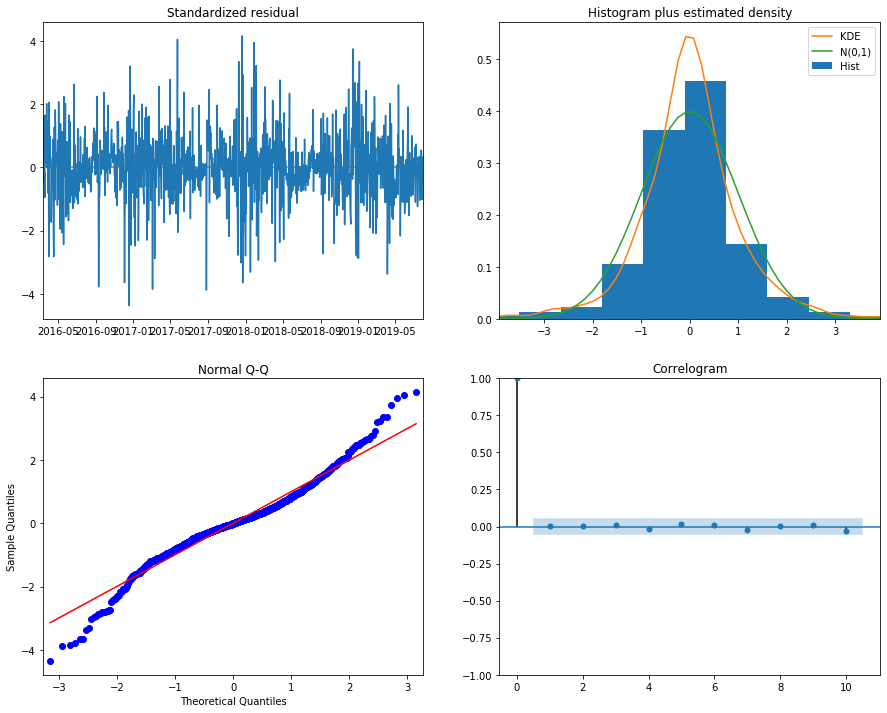

In [64]:
# Residual Diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### Validation 

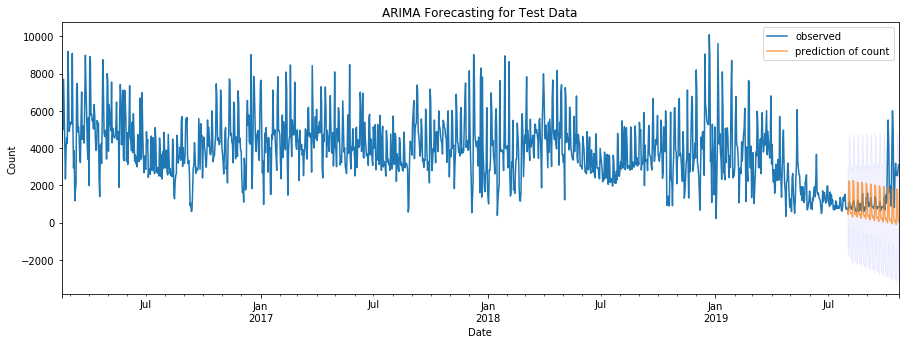

In [65]:
pred1 = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred1_ci = pred1.conf_int()
ax=multivariate_df_imputed['Butler Trail - Crenshaw Bridge PC Urban Trail'].plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='prediction of count', alpha=.7, figsize=(15,5))
ax.fill_between(pred1_ci.index,
                pred1_ci.iloc[:, 0],
                pred1_ci.iloc[:, 1], color='b', alpha=0.05)

ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title("ARIMA Forecasting for Test Data")
plt.legend()

### Evaluation 

In [67]:
#Actual number of trips for validation data
y_truth = test['Butler Trail - Crenshaw Bridge PC Urban Trail']

#Predicted number of trips for validation data
y_future=pred1.predicted_mean

In [68]:
print((abs(y_future - y_truth)/y_truth).mean())   ## MAPE
print(abs(y_future - y_truth).mean())             ## MAE

0.6762290760442905
995.5169375304037


In [245]:
abs(y_future - y_truth).mean()

996.237766299418

In [69]:
crenshaw_forecast = pd.concat([y_truth,y_future], axis = 1)
crenshaw_forecast.columns = ['Actual', 'Predicted']

In [70]:
crenshaw_forecast

,Actual,Predicted
2019-08-01,713.0,720.629480
2019-08-02,675.0,427.565566
2019-08-03,942.0,2237.328180
2019-08-04,1092.0,2088.597985
2019-08-05,798.0,636.925434
...,...,...
2019-10-18,2549.0,-101.909660
2019-10-19,2707.0,1801.531748
2019-10-20,2510.0,1634.719159
2019-10-21,2839.0,168.503135


### Random Forest 
We tried applying Random Forest Regression treating day, month and week of month as categorical variables. Following code chunk includes the code for Cross-validation to find the best parameters for the paramters of the Random Forest Regressor.

In [77]:
train, test = multivariate_df_imputed[:date_splitter], multivariate_df_imputed[date_splitter:]

In [78]:
X = train.reset_index().drop(['index','Date', 'week', 'year','Butler Trail - Crenshaw Bridge PC Urban Trail'], axis = 1)
y = train.reset_index()['Butler Trail - Crenshaw Bridge PC Urban Trail']

In [79]:
X

,month,day,PRCP,TMAX,TMIN,week_of_month
0,2,2,0.0,79,45,3.0
1,2,3,0.0,73,46,3.0
2,2,4,0.0,77,53,3.0
3,2,5,0.0,79,62,3.0
4,2,6,0.0,73,63,3.0
...,...,...,...,...,...,...
1257,7,6,0.0,96,67,4.0
1258,7,0,0.0,98,75,5.0
1259,7,1,0.0,99,75,5.0
1260,7,2,0.0,101,74,5.0


In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pprint import pprint


def rfr_model(X,y):
    #Grid Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth':range(3,7),
            'n_estimators':(2,3,4,5)
        },
        cv = 5, scoring = 'neg_mean_squared_error', verbose = 0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X,y)
    best_params = grid_result.best_params_
    
    rf_forecast = RandomForestRegressor(max_depth=best_params['max_depth'],
                                    n_estimators=best_params['n_estimators'],
                                    random_state=42, verbose=False, )

    #K-Fold CV
    scores = cross_val_score(rf_forecast, X, y, cv = 10, 
                            scoring = 'neg_mean_absolute_error')
    
    print('max_depth= ',best_params['max_depth'])
    print('n_estimators= ',best_params['n_estimators'])
    return scores.mean()

In [81]:
rfr_model(X,y)

C:\Users\mayan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



max_depth=  3
n_estimators=  4


-1084.1312850102818

In [82]:
#RandomForest Model Fitting
rf_forecast = RandomForestRegressor(max_depth= 3,
                                    n_estimators= 4,
                                    random_state=42, verbose=False)
rf_forecast.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=None,
                      oob_score=False, random_state=42, verbose=False,
                      warm_start=False)

In [83]:
#RandomForest Prediction
test = multivariate_df_imputed['2019-08-01':].drop(['Date','year','week'], axis = 1)
X_test = test.reset_index().drop(['index', 'Butler Trail - Crenshaw Bridge PC Urban Trail'], axis = 1)
y_future = rf_forecast.predict(X_test)
y_truth = test['Butler Trail - Crenshaw Bridge PC Urban Trail']

In [84]:
#Evaluation 
mape = ((abs(y_future - y_truth)/y_truth).mean())*100
mae = abs(y_future - y_truth).mean()
print(mape)
print(mae)

237.9393613874928
2254.9963734424728


day              0.565977
TMIN             0.241667
TMAX             0.160537
PRCP             0.019344
month            0.012475
week_of_month    0.000000
dtype: float64


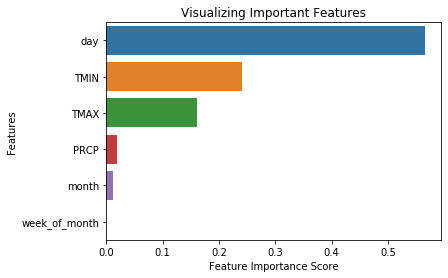

In [124]:
feature_imp = pd.Series(rf_forecast.feature_importances_,index=X.columns).sort_values(ascending=False)
print(feature_imp)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()